# Práctica 1

### Ejercicio 1

In [1]:
from PIL import Image
import numpy as np
from skimage.filters import threshold_otsu
import math

C:\Users\Jose Giner\Anaconda3\lib\site-packages\dask\config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
im = Image.open("words.png")
im.mode

'RGBA'

L


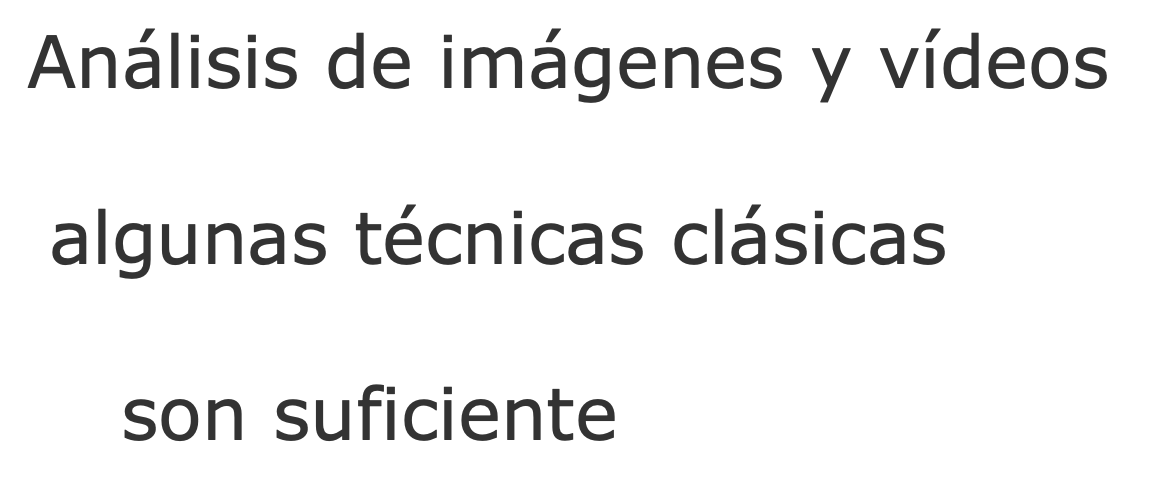

In [3]:
im = im.convert('L')
print(im.mode)
I = np.array(im)
im

In [4]:
np.histogram(I, bins = 256, range = (0,255))[0]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,  34041,    100,    124,    115,    113,
           68,    103,     75,     92,     64,     42,     53,     89,
           58,     55,     48,     80,     19,     58,     56,    147,
           45,     50,     46,     19,     58,     53,    222,     83,
           46,    121,     96,    158,     37,      6,     19,     50,
           43,     46,     40,     88,     53,    305,     57,     77,
           31,     43,     30,    103,     61,     19,     27,     93,
           36,     12,     25,    530,     41,     16,     32,     67,
      

In [5]:
def Otsu(I): 
    th = threshold_otsu(I)
    mask = np.zeros(I.shape)
    mask[I<=th] = 255
    mask = 255 - mask
        
    return mask

In [6]:
def Dilatado(I,size):
    
    B = np.zeros((size,size))
    res = np.full(I.shape,255)
    
    for i in range(I.shape[0] - size + 1):
        for j in range(I.shape[1] - size + 1):
            if B[0][0] in I[i:i+size, j:j+size]:
                res[i + size//2,j + size//2] = 0
    
    
    return res

In [7]:
def union_find(lis): 
    #Función que encuentra la unión de varios conjuntos que comparten elementos entre sí. 
    #Necesaria para la resolución de equivalencias en componentes conexas.
    lis = map(set, lis)
    unions = []
    for item in lis:
        temp = []
        for s in unions:
            if not s.isdisjoint(item):
                item = s.union(item)
            else:
                temp.append(s)
        temp.append(item)
        unions = temp
    return unions

In [8]:
def Label(I, bounding_box = False):
    
    #A continuación aplicamos componentes conexas. Empezamos con la primera pasada.
    comp_mat = np.zeros(I.shape)
    equivalencias = []
    componentes = 0

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i,j] == 0:
                pass
            
            elif i == 0 and j == 0:
                componentes += 1
                comp_mat[i,j] = componentes
            
            elif i == 0:
                if I[i,j] == I[i,j-1]:
                    comp_mat[i,j] = comp_mat[i,j-1]
                
                else:  #Creamos componente
                    componentes += 1
                    comp_mat[i,j] = componentes
            
            elif j == 0:
                if I[i,j] == I[i-1,j+1]:
                    comp_mat[i,j] = comp_mat[i-1,j+1]
                
                elif I[i,j] == I[i-1,j]:
                    comp_mat[i,j] = comp_mat[i-1,j]
                
                else:  #Creamos componente
                    componentes += 1
                    comp_mat[i,j] = componentes
        
            elif j == I.shape[1] - 1:
                if I[i,j] == I[i-1,j]:
                    comp_mat[i,j] = comp_mat[i-1,j]
                    
                elif I[i,j] == I[i-1,j-1]:
                    comp_mat[i,j] = comp_mat[i-1,j-1] 
                
                elif I[i,j] == I[i,j-1]:
                    comp_mat[i,j] = comp_mat[i,j-1]
                
                else:  #Creamos componente
                    componentes += 1
                    comp_mat[i,j] = componentes
                
                    
            else:
                comp_vecinos = [comp_mat[i-1,j+1], comp_mat[i-1,j], comp_mat[i-1,j-1] ,comp_mat[i,j-1]]
                if I[i,j] == I[i-1,j+1]:
                    comp_mat[i,j] = comp_mat[i-1,j+1]
                    
                elif I[i,j] == I[i-1,j]:
                    comp_mat[i,j] = comp_mat[i-1,j]
                    
                elif I[i,j] == I[i-1,j-1]:
                    comp_mat[i,j] = comp_mat[i-1,j-1] 
                
                elif I[i,j] == I[i,j-1]:
                    comp_mat[i,j] = comp_mat[i,j-1]
                
                else: #Creamos componente
                    componentes += 1
                    comp_mat[i,j] = componentes
                
                aux = set(cv for cv in comp_vecinos if cv != 0)
                if len(aux) > 1: #colisión de etiquetas encontrada
                    relacion = list(aux)
                    if relacion not in equivalencias:
                        equivalencias.append(relacion)  #Almacenamos la relación en una lista si no estaba antes
        
    
    #Segunda pasada para resolver equivalencias
    
    comp_no_aisladas = set(e for lista in equivalencias for e in lista)
    for comp in range(1,componentes+1):
        if comp not in comp_no_aisladas:
            equivalencias.append([comp])
    
    equivalencias = union_find(equivalencias) #Unimos las equivalencias

    dic_equivalencias = {}
    c = 1
    for clase in equivalencias:
        dic_equivalencias[c] = clase
        c += 1

        
    #Creamos la matriz final de componentes con las equivalencias resueltas  
    final_comp_matrix = np.zeros(comp_mat.shape)
    for i in range(comp_mat.shape[0]):
        for j in range(comp_mat.shape[1]):
            for k in dic_equivalencias.keys():
                if comp_mat[i,j] in dic_equivalencias[k]:
                    final_comp_matrix[i,j] = k
     
    #Dibujamos la caja de mínima inclusión en caso de que el parámetro bounding_box sea True
    if bounding_box:
        final_comp_matrix_bb = final_comp_matrix.copy()
        for comp in dic_equivalencias:
            lista_indices = []
            for i in range(final_comp_matrix.shape[0]):
                for j in range(final_comp_matrix.shape[1]):
                    if final_comp_matrix[i,j] == comp:
                        lista_indices.append((i,j))

            min_x = min(lista_indices, key = lambda t: t[0])[0]
            max_x = max(lista_indices, key = lambda t: t[0])[0]
            min_y = min(lista_indices, key = lambda t: t[1])[1]
            max_y = max(lista_indices, key = lambda t: t[1])[1]

            for x in range(min_x, max_x + 4):
                final_comp_matrix_bb[x-3:x,min_y -3: min_y] = len(dic_equivalencias) + 1
                final_comp_matrix_bb[x-3:x,max_y: max_y + 3] = len(dic_equivalencias) + 1

            for y in range(min_y, max_y + 4):
                final_comp_matrix_bb[min_x -3: min_x , y-3:y] = len(dic_equivalencias) + 1
                final_comp_matrix_bb[max_x :max_x + 3,y-3:y] = len(dic_equivalencias) + 1
                    
        return final_comp_matrix_bb

    return final_comp_matrix
            

In [9]:
def deteccionTexto(I):
    
    #Primero aplicamos Otsu para umbralizar la imagen de entrada
    mask = Otsu(I)

    S1 = Dilatado(mask,15)

    S2 = abs(S1 - 255)

    comp_matrix = Label(S2, bounding_box = True)
    
    im = np.uint8(I)
    im_RGB = Image.fromarray(im).convert('RGB')
    I2 = np.array(im_RGB)
    
    componente_caja = np.amax(comp_matrix)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if comp_matrix[i,j] == componente_caja:
                I2[i,j,0] = 0
                I2[i,j,1] = 0
                I2[i,j,2] = 255

    im2 = Image.fromarray(I2)
    
    return im2

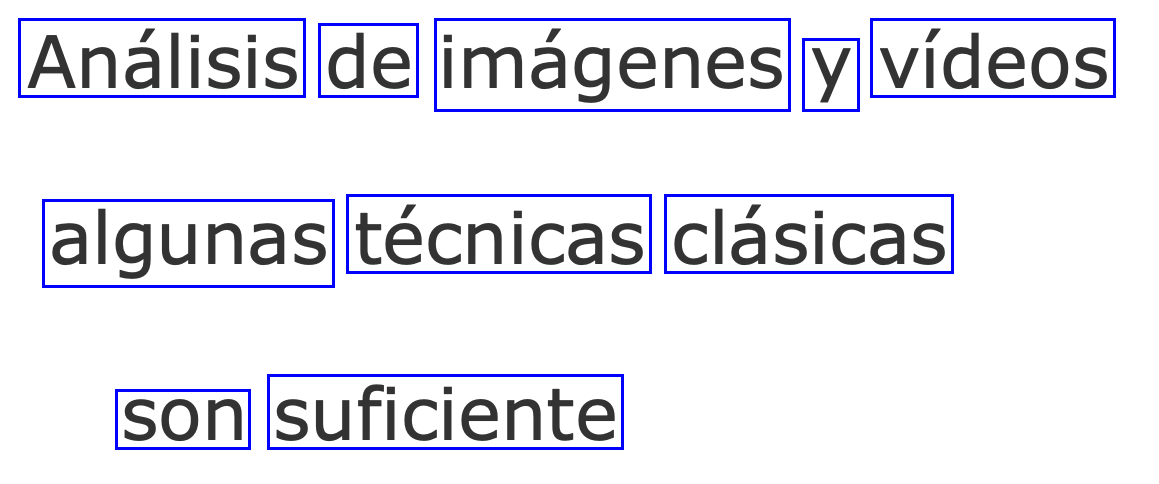

In [10]:
S = deteccionTexto(I)
S